# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** first name and last name  
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.0 Brain image visualization

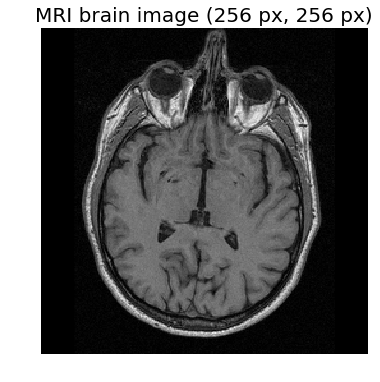

In [116]:
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.1 Package imports and General observation

In [33]:
#Necessary packages to run the notebook
import numpy as np
import scipy.ndimage as ndimage
from skimage import data
from skimage import filters
from skimage import exposure
from skimage import measure
from skimage.filters import sobel
from skimage.morphology import watershed
from skimage.segmentation import flood_fill

#Plot standard
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['figure.figsize'] = (15, 8)

mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14

#Method used for contour detection
def largest_contour_index(contours):
    '''Takes a list of countours and return the largest contour'''
    contours_ = np.array(contours)
    max_size = 0
    max_ind = 0
    for index, contour in enumerate(contours_):
        size = contour.size
        if size > max_size:
            max_size = size
            max_ind = index
    return max_ind

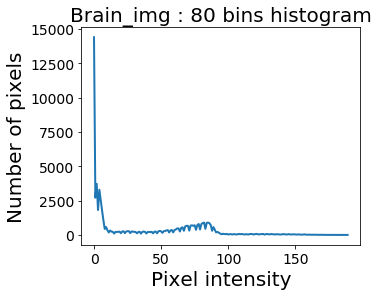

In [29]:
#Let's discover image distribution
nb_bins = 80

##Displays histogram
camera = brain_im
hist, bins_center = exposure.histogram(camera)
fig = plt.figure(figsize=(5, 4))
plt.plot(bins_center, hist, lw=2)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('Brain_img : {} bins histogram'.format(nb_bins))

plt.show()

#### Discussion:
At first glance, histogram says that most of pixels are black and the other are gray-dark. Looking at the brain_im file we can say that big spike corresponds to the background. The skull image is spred in pixel intensity between 50 and 100.

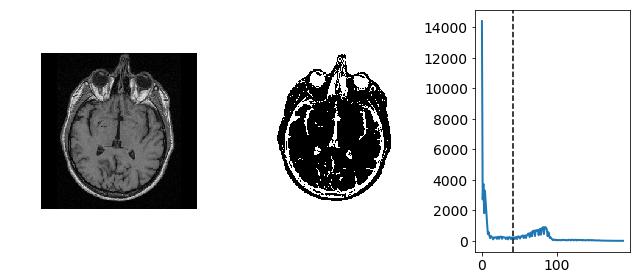

In [30]:
#Thanks to otsu threshold automatic detection we manage to find optimal threshold.

val = filters.threshold_otsu(brain_im)

hist, bins_center = exposure.histogram(brain_im)

plt.figure(figsize=(9, 4))
plt.subplot(131)
plt.imshow(camera, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(132)
plt.imshow(camera < val, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(133)
plt.plot(bins_center, hist, lw=2)
plt.axvline(val, color='k', ls='--')

plt.tight_layout()
plt.show()

#### Discussion:
As predicted above, threshold that split foreground from background find that relevent information lies above 50 of intensity.

### 1.2 Region growing
Add your implementation and discussion

Following: 
           - http://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html
           - http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_floodfill.html

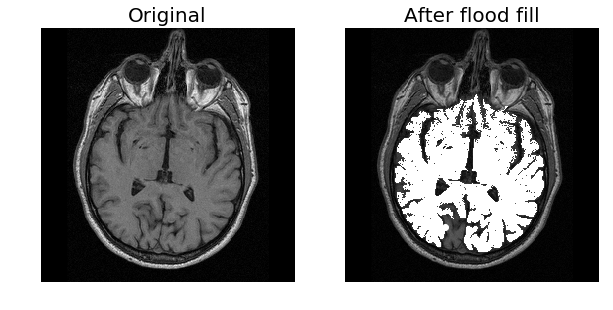

In [31]:
#Use a pixel in the brain to switch all pixel with tolerance 15 to 255 insensity.
point_in_brain = (100,100)
color_switch = 255
light_brain = flood_fill(brain_im, point_in_brain, color_switch, tolerance=15)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].imshow(brain_im, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(light_brain, cmap=plt.cm.gray)
ax[1].plot(100, 200, 'wo')  # seed point
ax[1].set_title('After flood fill')
ax[1].axis('off')

plt.show()

In [32]:
pix_size = int(light_brain[light_brain==255].sum()/255)
print('Size in pixels of the brain captured by flod_fill: {} pixels'.format(pix_size))

Size in pixels of the brain captured by flod_fill: 13881 pixels


#### Discussion

In the figure above, we see by comparison with the original image that flood_fill is quite precise regarding the shape of the brain contour of the brain.
However, it's not able to capture the down left part which is easy to spot. May be due to strong edges that prevent algorithm to get in this part

### 1.3 Contour detection
Add your implementation and discussion

In [79]:
copy = brain_im.copy()
copy2 = brain_im.copy()
#Trick to allow algorithm to differenciate contour from external part of skull and internal part.
#  => Set a black line to cut the brain from the external part
copy[82, 150:170] = 0

# Find contours at a constant value of 55
contours = measure.find_contours(copy, 55, 'high')
contours_normal = measure.find_contours(copy2, 55, 'high')

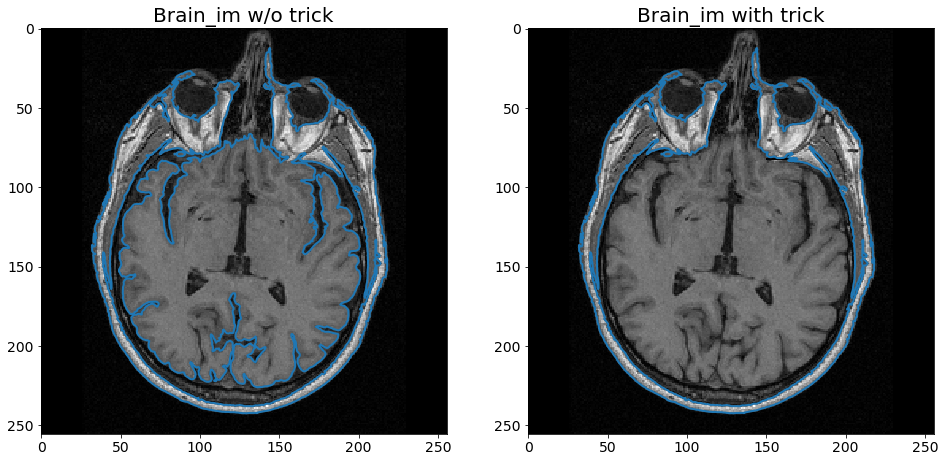

In [80]:
# Display the image and plot for largest contour
fig, ax = plt.subplots(1, 2, figsize=(16,8))

ax[0].imshow(copy2, interpolation='nearest', cmap='gray')
ax[1].imshow(copy, interpolation='nearest', cmap='gray')


ind_largest_cont = largest_contour_index(contours)
ind_largest_cont_normal = largest_contour_index(contours_normal)

ax[0].plot(np.array(contours_normal)[ind_largest_cont_normal][:, 1],
           np.array(contours_normal)[ind_largest_cont_normal][:, 0], linewidth=2)
ax[1].plot(np.array(contours)[ind_largest_cont][:, 1], np.array(contours)[ind_largest_cont][:, 0], linewidth=2)

ax[0].set_title('Brain_im w/o trick')
ax[1].set_title('Brain_im with trick')

plt.show()

#### Discussion
See that without the trick, the contour taks both the brain and the external part. And otherwise, only the external part is contoured

In [81]:
#Lets create an mask that will be used to remove external part of the image and isolate th brain

# Create an empty image to store the masked array
extern_mask = np.zeros_like(copy, dtype='bool')

# Create a contour image by using the contour coordinates rounded to their nearest integer value
extern_mask[np.round(contours[ind_largest_cont][:, 0]).astype('int'), np.round(contours[ind_largest_cont][:, 1]).astype('int')] = 1

# Fill in the hole created by the contour boundary
extern_mask = ndimage.binary_fill_holes(extern_mask)

# Invert the mask since you want pixels outside of the region
#r_mask = ~r_mask

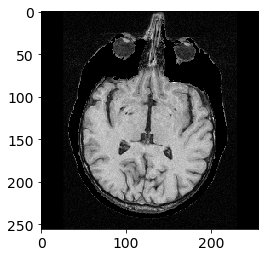

In [82]:
#Set all values within the mask to 0
copy[extern_mask] = 0
plt.imshow(copy, cmap='gray')
plt.show()

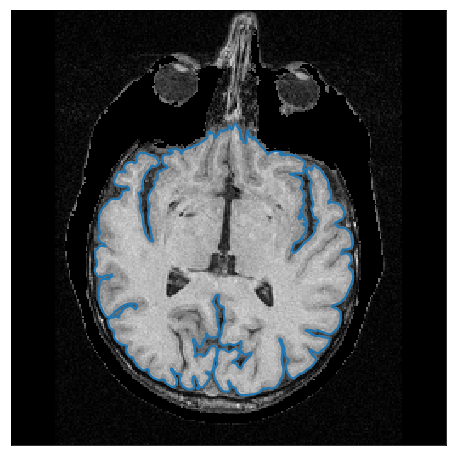

In [83]:
#Now applying the find contours method allows to get the contour of the brain only.
brain_contours = measure.find_contours(copy, 55, 'high')

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
ax.imshow(copy, interpolation='nearest', cmap='gray')


ind_largest_cont = largest_contour_index(brain_contours)
ax.plot(np.array(brain_contours)[ind_largest_cont][:, 1],
        np.array(brain_contours)[ind_largest_cont][:, 0], linewidth=2)


import scipy.ndimage as ndimage    

# ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [84]:
#Lets create a final mask which allows to remove everything but the brain
# Create an empty image to store the masked array
b_mask = np.zeros_like(copy, dtype='bool')

# Create a contour image by using the contour coordinates rounded to their nearest integer value
b_mask[np.round(brain_contours[ind_largest_cont][:, 0]).astype('int'), 
       np.round(brain_contours[ind_largest_cont][:, 1]).astype('int')] = 1

# Fill in the hole created by the contour boundary
b_mask = ndimage.binary_fill_holes(b_mask)




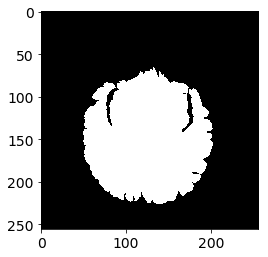

In [86]:
copy[b_mask] = 255
copy[copy != 255] = 0
plt.imshow(copy, cmap='gray')
plt.show()

In [87]:
pixels_size = copy[copy == 255].sum()/255
print('Size in pixels of the brain captured by flod_fill: {} pixels'.format(pixels_size))

Size in pixels of the brain captured by flod_fill: 17957.0 pixels


#### Discussion
Here the external shape is better than the previous method since we managed to encapture all the parts of the brain. However, we are not able here remove internal empty parts. May be with more hyperparameters finetuning.

The brain size in pixels is coherent with the previous method result. Indeed, previously we get 138881 pxs but had less external part of the brain and removed empty space inside. Which is consistant with a 17957-13881 = 4070 pixs difference.

### 1.4 Additional method(s)
Add your implementation and discussion

Crédits to skimage tutorials

Text(0.5, 1.0, 'elevation_map')

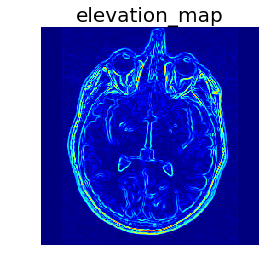

In [117]:
#Get the elevation map of the brain_im
elevation_map = sobel(brain_im)

plt.figure()
plt.imshow(elevation_map, cmap='jet', interpolation='nearest')
plt.axis('off')
plt.title('elevation_map')

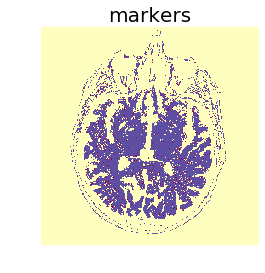

In [118]:
#Goal is to attribute labels to specific range of intensity
markers = np.zeros_like(brain_im)

###Best solution so far
min_thres = 69
max_thres = 90
markers[brain_im < min_thres] = 1
markers[brain_im > max_thres] = 1
markers[(brain_im > min_thres) & (brain_im < max_thres)] = 2
#####

###Second best solution
# markers[brain_im < 45] = 1
# markers[brain_im > 90] = 1
# markers[(brain_im > 55) & (brain_im < 90)] = 2
###

plt.figure()
plt.imshow(markers, cmap='Spectral', interpolation='nearest')
plt.axis('off')
plt.title('markers')
plt.show()

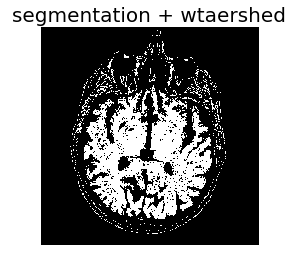

In [119]:
#Get segmentation of brain_im
segmentation = watershed(elevation_map, markers)

plt.figure()
plt.imshow(segmentation, cmap='gray', interpolation='nearest')
plt.axis('off')
plt.title('segmentation + wtaershed')
plt.show()

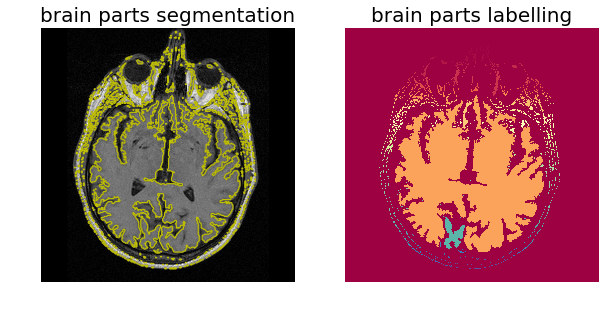

In [120]:
#Thanks to binary_fill_holes we are able to label each part of the brain.
segmentation = ndimage.binary_fill_holes(segmentation - 1)
labeled_brain, _ = ndimage.label(segmentation)

plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(brain_im, cmap='gray', interpolation='nearest')
plt.contour(segmentation, [0.5], linewidths=1.2, colors='y')
plt.axis('off')
plt.title('brain parts segmentation')
plt.subplot(122)
plt.imshow(labeled_brain, cmap='Spectral', interpolation='nearest')
plt.axis('off')
plt.title('brain parts labelling')
plt.show()


In [138]:
brain_label = labeled_brain[150, 100]

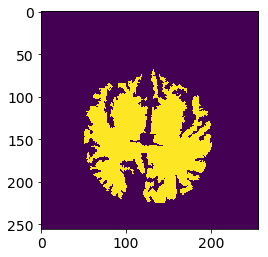

In [139]:
brain = (labeled_brain == brain_label)

plt.imshow(brain)


In [61]:
brain_size_pixels = np.sum(brain)

In [140]:

pixels_size_last = np.sum(brain)
print('Size in pixels of the brain captured by flod_fill: {} pixels'.format(pixels_size_last))

Size in pixels of the brain captured by flod_fill: 12880 pixels


#### Discussion
Brain is much more shrinked but this time we got nearly all intern holes. However like in first method, we lsot the little down left part of the brain

## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

Here, we visualize the 4 images for our patern detection

In [ ]:
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

In [1]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

NameError: name 'plt' is not defined

We can as well add the groud truth label that are stored in the corresponding XML files. Each xml file stores the position of the varroa on the image as :

```xml
<annotation>
	<object>
		<name>Varroa</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>117</ymin>
			<xmax>33</xmax>
			<ymax>137</ymax>
		</bndbox>
	</object>
	<object>
		...
	</object>
	...
</annotation>
```
The block `object` defines the attributes of the varroa. `name` is the definition of the object class (always varroa). `bndbox` is the definition of the bounding box. To simplify your task, we implemented a function named `parse_file` that returns an array with the bounding box of the varroa expressed as `(x, y, width, heigth)` which corresponds to `(xmin, ymin, xmax-xmin, ymax-ymin)`

In [ ]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [ ]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]

In [ ]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Count the number of Varroa on each picture

Add your implementation and discussion

Hint: `skimage.measure.label` might be useful to label the thresholded image

### 2.3 IoU of the detected pattern w.r.t. the ground truth

Add your implementation and discussion

Hint: `skimage.measure.regionprops` implements a large variety of descriptors

### 2.4 Precision, Recall and F1-score at two different IoU thresholds

Add your implementation and discussion